## SIT Data Visualization
- Ver. 1.0:  06-Aug-2025

### Libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from utilities import downsample, tool_wear_data

DATA = 'PROC_7'
DATA_FILE = f'data\{DATA}.csv'
DATA_FILE_DS = f'data\DS_{DATA}.csv'
SAVE_PLOT = f'data\FeaturesPlot_{DATA}.jpg'
DATA_FILE

'data\\PROC_7.csv'

### Function: Features Plot

- ``` Vib_Spindle, Vib_Table, Sound_Spindle, Sound_table, X_Load_Cell, Y_Load_Cell, Z_Load_Cell, Current``` 
- ``` tool_wear, RUL, ACTION_CODE ```

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

def plot_sensor_data(df, data_file_name, smoothing=None):
    """
    Generates a 3x3 multi-plot of sensor data with optional smoothing.

    Args:
        df (pd.DataFrame): The input DataFrame containing sensor data,
                           with a 'time' column and feature columns.
        smoothing (int, optional): If an integer > 0, it will be used as the
                                   rolling window size for smoothing the data.
                                   If 0 or None, no smoothing will be applied.
    """
    # Define features and their plotting order/grouping
    # Features listed: Vib_Spindle, Vib_Table, Sound_Spindle, Sound_table,
    # X_Load_Cell, Y_Load_Cell, Z_Load_Cell, Current.
    features_to_plot = {
        (0, 0): 'Vib_Spindle',
        (0, 1): 'Vib_Table',
        (0, 2): 'Current',
        (1, 0): 'X_Load_Cell',
        (1, 1): 'Y_Load_Cell',
        (1, 2): 'Z_Load_Cell',
        (2, 0): 'Sound_Spindle',
        (2, 1): 'Sound_table',
    }

    # Set a pastel color palette using seaborn
    pastel_palette = sns.color_palette("pastel", 5)

    # Assign specific colors for each group of features
    color_group1_vib = pastel_palette[0]      # For Vib_Spindle, Vib_Table
    color_group1_current = pastel_palette[1]  # For Current
    color_group2_load = pastel_palette[2]     # For X_Load_Cell, Y_Load_Cell, Z_Load_Cell
    color_group3_sound = pastel_palette[3]    # For Sound_Spindle, Sound_table

    # Create the 3x3 multi-plot figure and axes
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    # Determine the main title based on whether smoothing is applied
    main_title = f'Sensor Data File: {data_file_name} | Raw Features ' 
    if smoothing is not None and smoothing > 0:
        main_title = f'{main_title} (Smoothed with window={smoothing})'
    else:
        main_title = main_title + ' (No Smoothing)'
    fig.suptitle(main_title, fontsize=20, y=0.95)

    # Iterate through the defined features and their positions in the grid
    for (row, col), feature_name in features_to_plot.items():
        ax = axes[row, col]

        # Apply rolling mean for smoothing the data conditionally
        if smoothing is not None and smoothing > 0:
            # min_periods=1 ensures that even if there aren't enough points for the full window
            # at the start of the series, a mean is still calculated from available points.
            data_to_plot = df[feature_name].rolling(window=smoothing, min_periods=1).mean()
            y_label_suffix = ' (Smoothed)'
        else:
            data_to_plot = df[feature_name]
            y_label_suffix = ''

        # Determine the plotting color based on the feature group
        if feature_name in ['Vib_Spindle', 'Vib_Table']:
            plot_color = color_group1_vib
        elif feature_name == 'Current':
            plot_color = color_group1_current
        elif feature_name in ['X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell']:
            plot_color = color_group2_load
        elif feature_name in ['Sound_Spindle', 'Sound_table']:
            plot_color = color_group3_sound
        else:
            plot_color = 'gray' # Fallback color

        # Plot the data
        ax.plot(df['Time'], data_to_plot, color=plot_color, linewidth=3)
        ax.set_title(feature_name, fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel(f'Value{y_label_suffix}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

    # Hide the last subplot (bottom-right cell, which is at axes[2, 2])
    axes[2, 2].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])

    # Save as JPEG
    plt.savefig(SAVE_PLOT, bbox_inches='tight', dpi=300)
    print('Saved plot in {SAVE_PLOT}.')

    # Display the generated plot
    plt.show()

In [31]:
def plot_sensor_data_with_wear(df, data_file_name, smoothing=None):
    """
    Clone of plot_sensor_data with added tool wear plot in the last cell.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing sensor data and tool wear
        data_file_name (str): Name of the data file for the title
        smoothing (int, optional): Rolling window size for smoothing
    """
    features_to_plot = {
        (0, 0): 'Vib_Spindle',
        (0, 1): 'Vib_Table',
        (0, 2): 'Current',
        (1, 0): 'X_Load_Cell',
        (1, 1): 'Y_Load_Cell',
        (1, 2): 'Z_Load_Cell',
        (2, 0): 'Sound_Spindle',
        (2, 1): 'Sound_table',
        (2, 2): 'tool_wear'  # Added tool wear as the last plot
    }

    # Set a pastel color palette using seaborn
    pastel_palette = sns.color_palette("pastel", 5)

    # Assign colors for each group of features
    color_group1_vib = pastel_palette[0]      
    color_group1_current = pastel_palette[1]   
    color_group2_load = pastel_palette[2]      
    color_group3_sound = pastel_palette[3]     

    # Create the 3x3 multi-plot figure and axes
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    # Determine the main title
    main_title = f'Sensor Data File: {data_file_name} | Raw Features and Tool Wear' 
    if smoothing is not None and smoothing > 0:
        main_title = f'{main_title} (Smoothed with window={smoothing})'
    else:
        main_title = main_title + ' (No Smoothing)'
    fig.suptitle(main_title, fontsize=20, y=0.95)

    # Iterate through features and plot
    for (row, col), feature_name in features_to_plot.items():
        ax = axes[row, col]

        # Set light grey background for tool wear plot
        if feature_name == 'tool_wear':
            ax.set_facecolor('#f5f5f5')  # Light grey background

        # Apply smoothing if specified, but not for tool_wear
        if smoothing is not None and smoothing > 0 and feature_name != 'tool_wear':
            data_to_plot = df[feature_name].rolling(window=smoothing, min_periods=1).mean()
            y_label_suffix = ' (Smoothed)'
        else:
            data_to_plot = df[feature_name]
            y_label_suffix = ''

        # Determine plot color
        if feature_name == 'tool_wear':
            plot_color = "#676778"  # Very dark grey for tool wear
        elif feature_name in ['Vib_Spindle', 'Vib_Table']:
            plot_color = color_group1_vib
        elif feature_name == 'Current':
            plot_color = color_group1_current
        elif feature_name in ['X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell']:
            plot_color = color_group2_load
        elif feature_name in ['Sound_Spindle', 'Sound_table']:
            plot_color = color_group3_sound
        else:
            plot_color = 'gray'

        # Plot the data
        ax.plot(df['Time'], data_to_plot, color=plot_color, linewidth=3)
        ax.set_title(feature_name, fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel(f'Value{y_label_suffix}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])

    # Save plot
    plt.savefig(SAVE_PLOT, bbox_inches='tight', dpi=300)
    print(f'Saved plot in {SAVE_PLOT}.')

    plt.show()

### Read data and plot

In [32]:
# Read the CSV file
df_raw = pd.read_csv(DATA_FILE)
df = downsample(df_raw, 6)
df.to_csv(DATA_FILE_DS, index=False)

- Down-sampling. Input data records: 400. Sampling rate: 6. Expected rows 67.    Down-sampled to 67 rows.


Saved plot in data\FeaturesPlot_PROC_7.jpg.


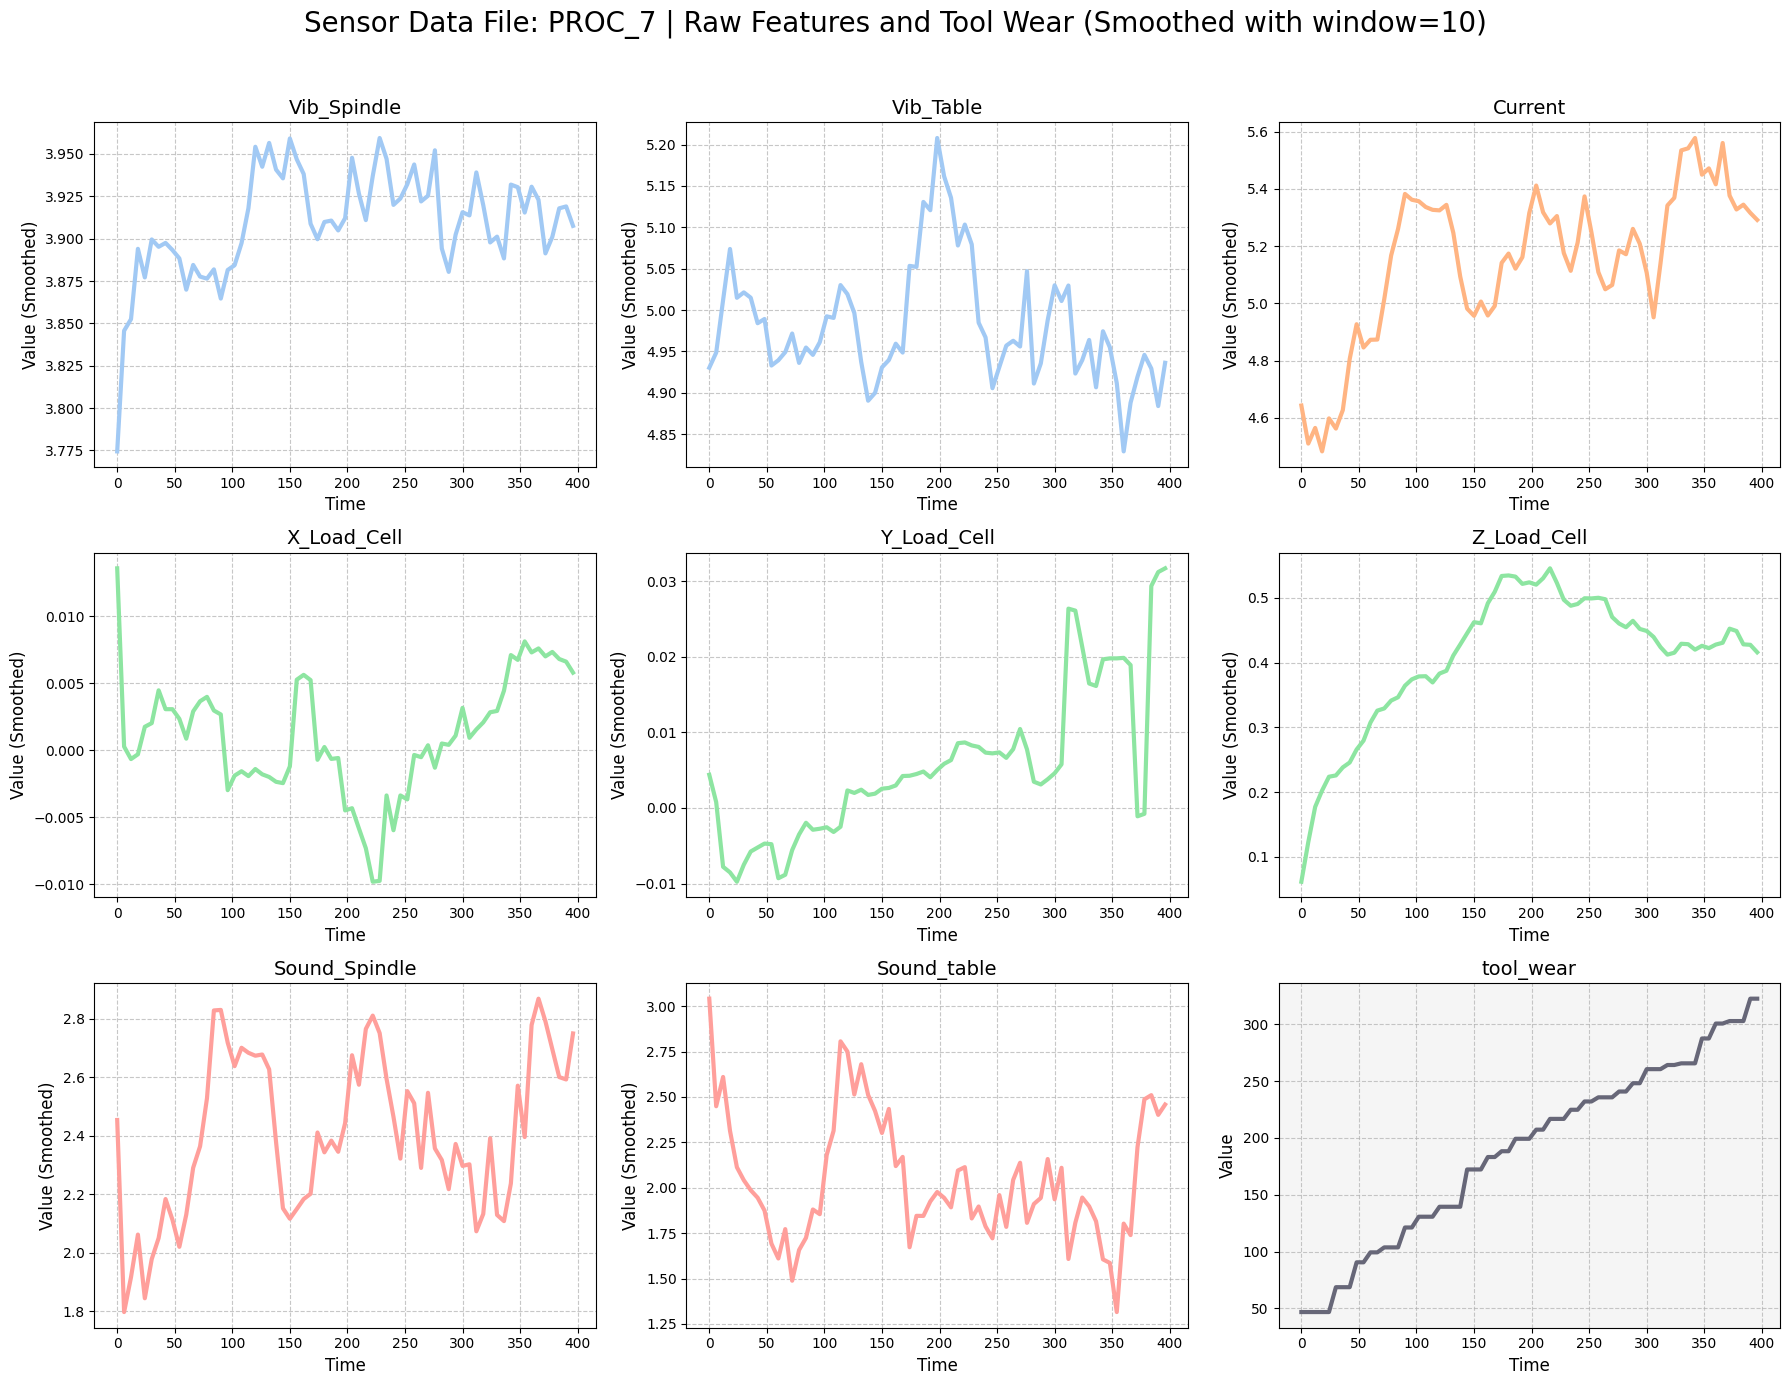

In [33]:
# plot_sensor_data(df, smoothing=0)
# plot_sensor_data(df, smoothing=None)
# plot_sensor_data(df, DATA, smoothing=100)
plot_sensor_data_with_wear(df, DATA, smoothing=10)

In [35]:
# # Create Training data
# _, _, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
#     env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
#     normalize=False, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

# records = len(df_train.index)
# MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records
# rul_threshold_record_train = df_train.loc[df_train['tool_wear'] >= WEAR_THRESHOLD_NORMALIZED].index[0]
# rul_threshold_train = df_train.loc[df_train.index[rul_threshold_record_train], 'RUL']

# # Create Test data
# _, _, TEST_WEAR_THRESHOLD_NORMALIZED, df_test = tool_wear_data(
#     env_type = ENV_TYPE, data_file=TEST_DATA_FILE, wear_threshold = TEST_WEAR_THRESHOLD,
#     normalize=True, add_noise=False, sampling_rate = SAMPLING_RATE)

# n_test_records = len(df_test.index)
# rul_threshold_record_test = df_test.loc[df_test['tool_wear'] >= TEST_WEAR_THRESHOLD_NORMALIZED].index[0]
# rul_threshold_test = df_test.loc[df_test.index[rul_threshold_record_test], 'RUL']

# print(f'TRAIN - RUL threshold at time {rul_threshold_record_train} is {rul_threshold_train:3.3f}, and wear threshold {WEAR_THRESHOLD:3.3f}')
# print(f'TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}, and wear threshold {TEST_WEAR_THRESHOLD:3.3f}')